In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [144]:
from scripts import importdata, mercator

In [230]:
total_coords = []
total_alphas = []
for i in range(1, 10):
    data = pd.read_csv('data/new.150119.010/new.010.00' + str(i) + '.info.yml.gz.csv', names=['x', 'y', 'steering'])
    coords = data[['x', 'y']].to_numpy()
    alphas = ( data[['steering']].to_numpy() / 180 ) * np.pi
    if i==1:
        total_coords = coords
        total_alphas = alphas
    else:
        total_coords = np.vstack((total_coords, coords))
        total_alphas = np.append(total_alphas, alphas)
total_coords = np.array(mercator.Mercator(total_coords))#.reshape(900, 2)

55.62403814985842


In [231]:
X = np.array(total_coords[0])
Y = np.array(total_coords[1])

data = np.vstack((X,Y)).T

### Extract constant radius arcs

In [148]:
arcs = []
for i, alpha in enumerate(total_alphas):
    if i == 0:
        prev_alpha = alpha
        cur_arc = [[data[i][0], data[i][1], alpha]]
    else:
        if alpha == prev_alpha:
            cur_arc.append([data[i][0], data[i][1], alpha])
        else:
            arcs.append(cur_arc)
            prev_alpha = alpha
            cur_arc = [[data[i][0], data[i][1], alpha]]

Keep only those with $\geq 3$ points. 

In [169]:
long_arcs = []
for arc in arcs:
    if len(arc) >= 3:
        long_arcs.append(arc)

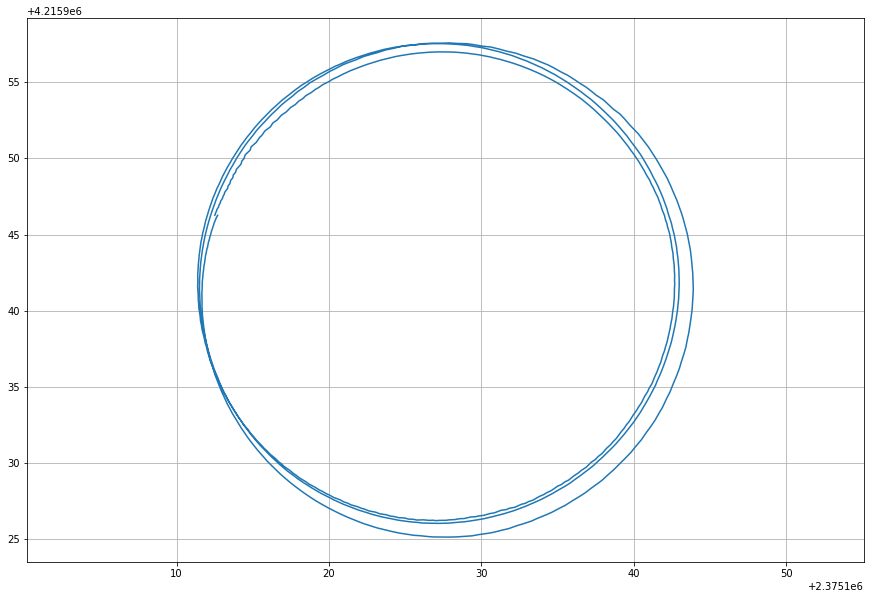

In [217]:
plt.figure(figsize=(15,10))
plt.plot(X, Y)
plt.grid(True)
plt.axis('equal')
plt.show()

### Приближение окружностями

Приблизим окружностями те дуги проезда, для которых измеренные значения steering постоянны.

In [153]:
import circle_fit as cf

In [186]:
# arcs = []
circles = []

for arc in long_arcs:
    xc, yc, r, _ = cf.least_squares_circle(np.array(arc)[:, [0, 1]])
    circles.append([xc, yc, r])

In [187]:
assert len(circles) == len(long_arcs)

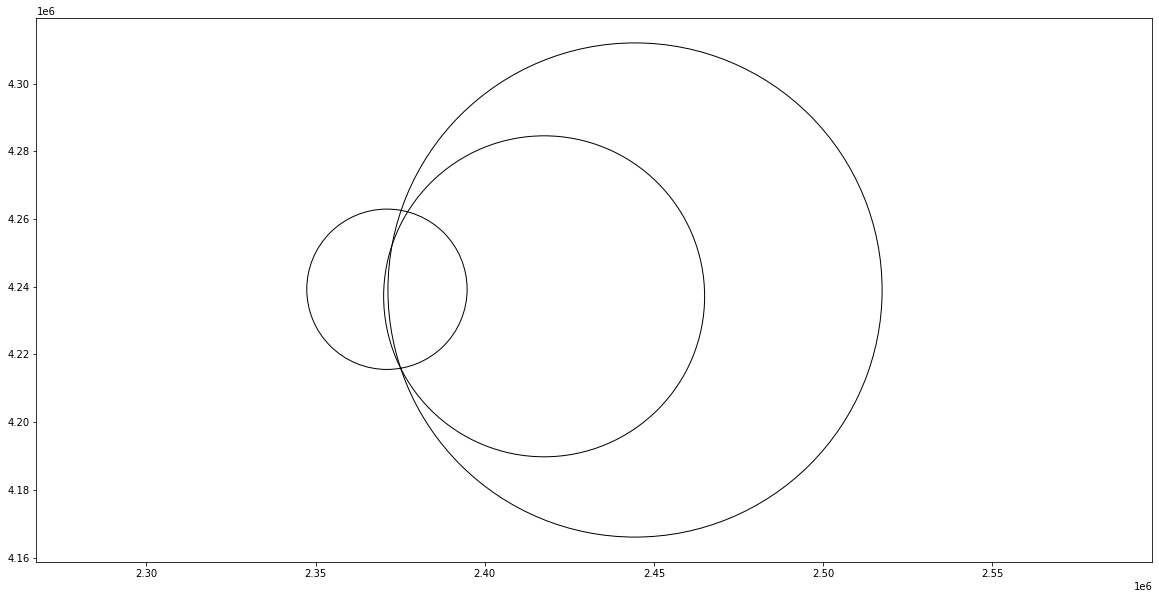

In [236]:
def print_circles(circles):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.cla() # clear things for fresh plot
        
    for circle in circles:
        xc, yc, r = circle
        c = plt.Circle((xc, yc), r, fill=False)
        ax.add_patch(c)
    
    plt.axis('equal')
    plt.plot()
    

print_circles(circles)

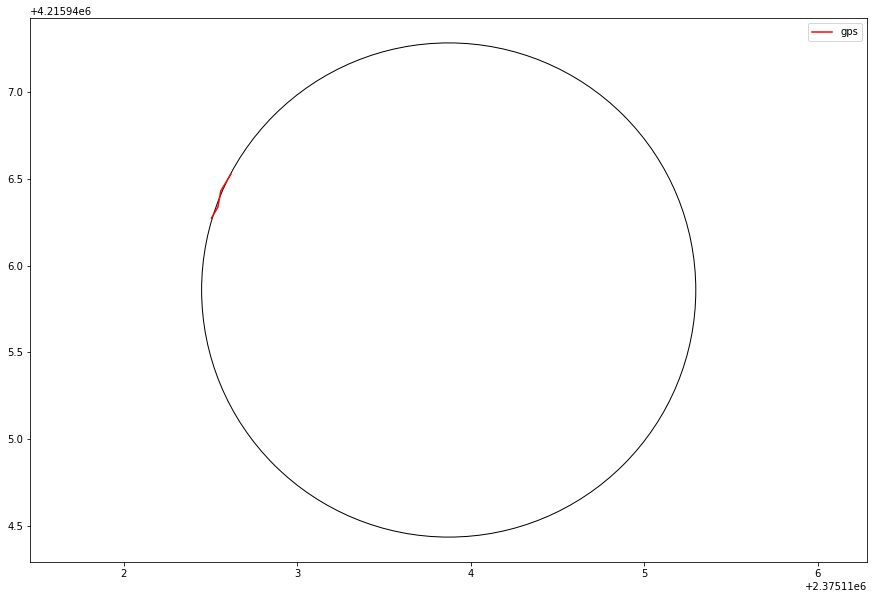

In [221]:
for circle, arc in zip(circles, long_arcs):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.cla()
    
    ax.plot(np.array(arc)[:, 0], np.array(arc)[:, 1], color='red', label='gps')
    
    xc, yc, r = circle
    c = plt.Circle((xc, yc), r, fill=False)
    ax.add_patch(c)
    
    plt.axis('equal')
    plt.legend()
    plt.plot()
    break

### Угол поворота колес

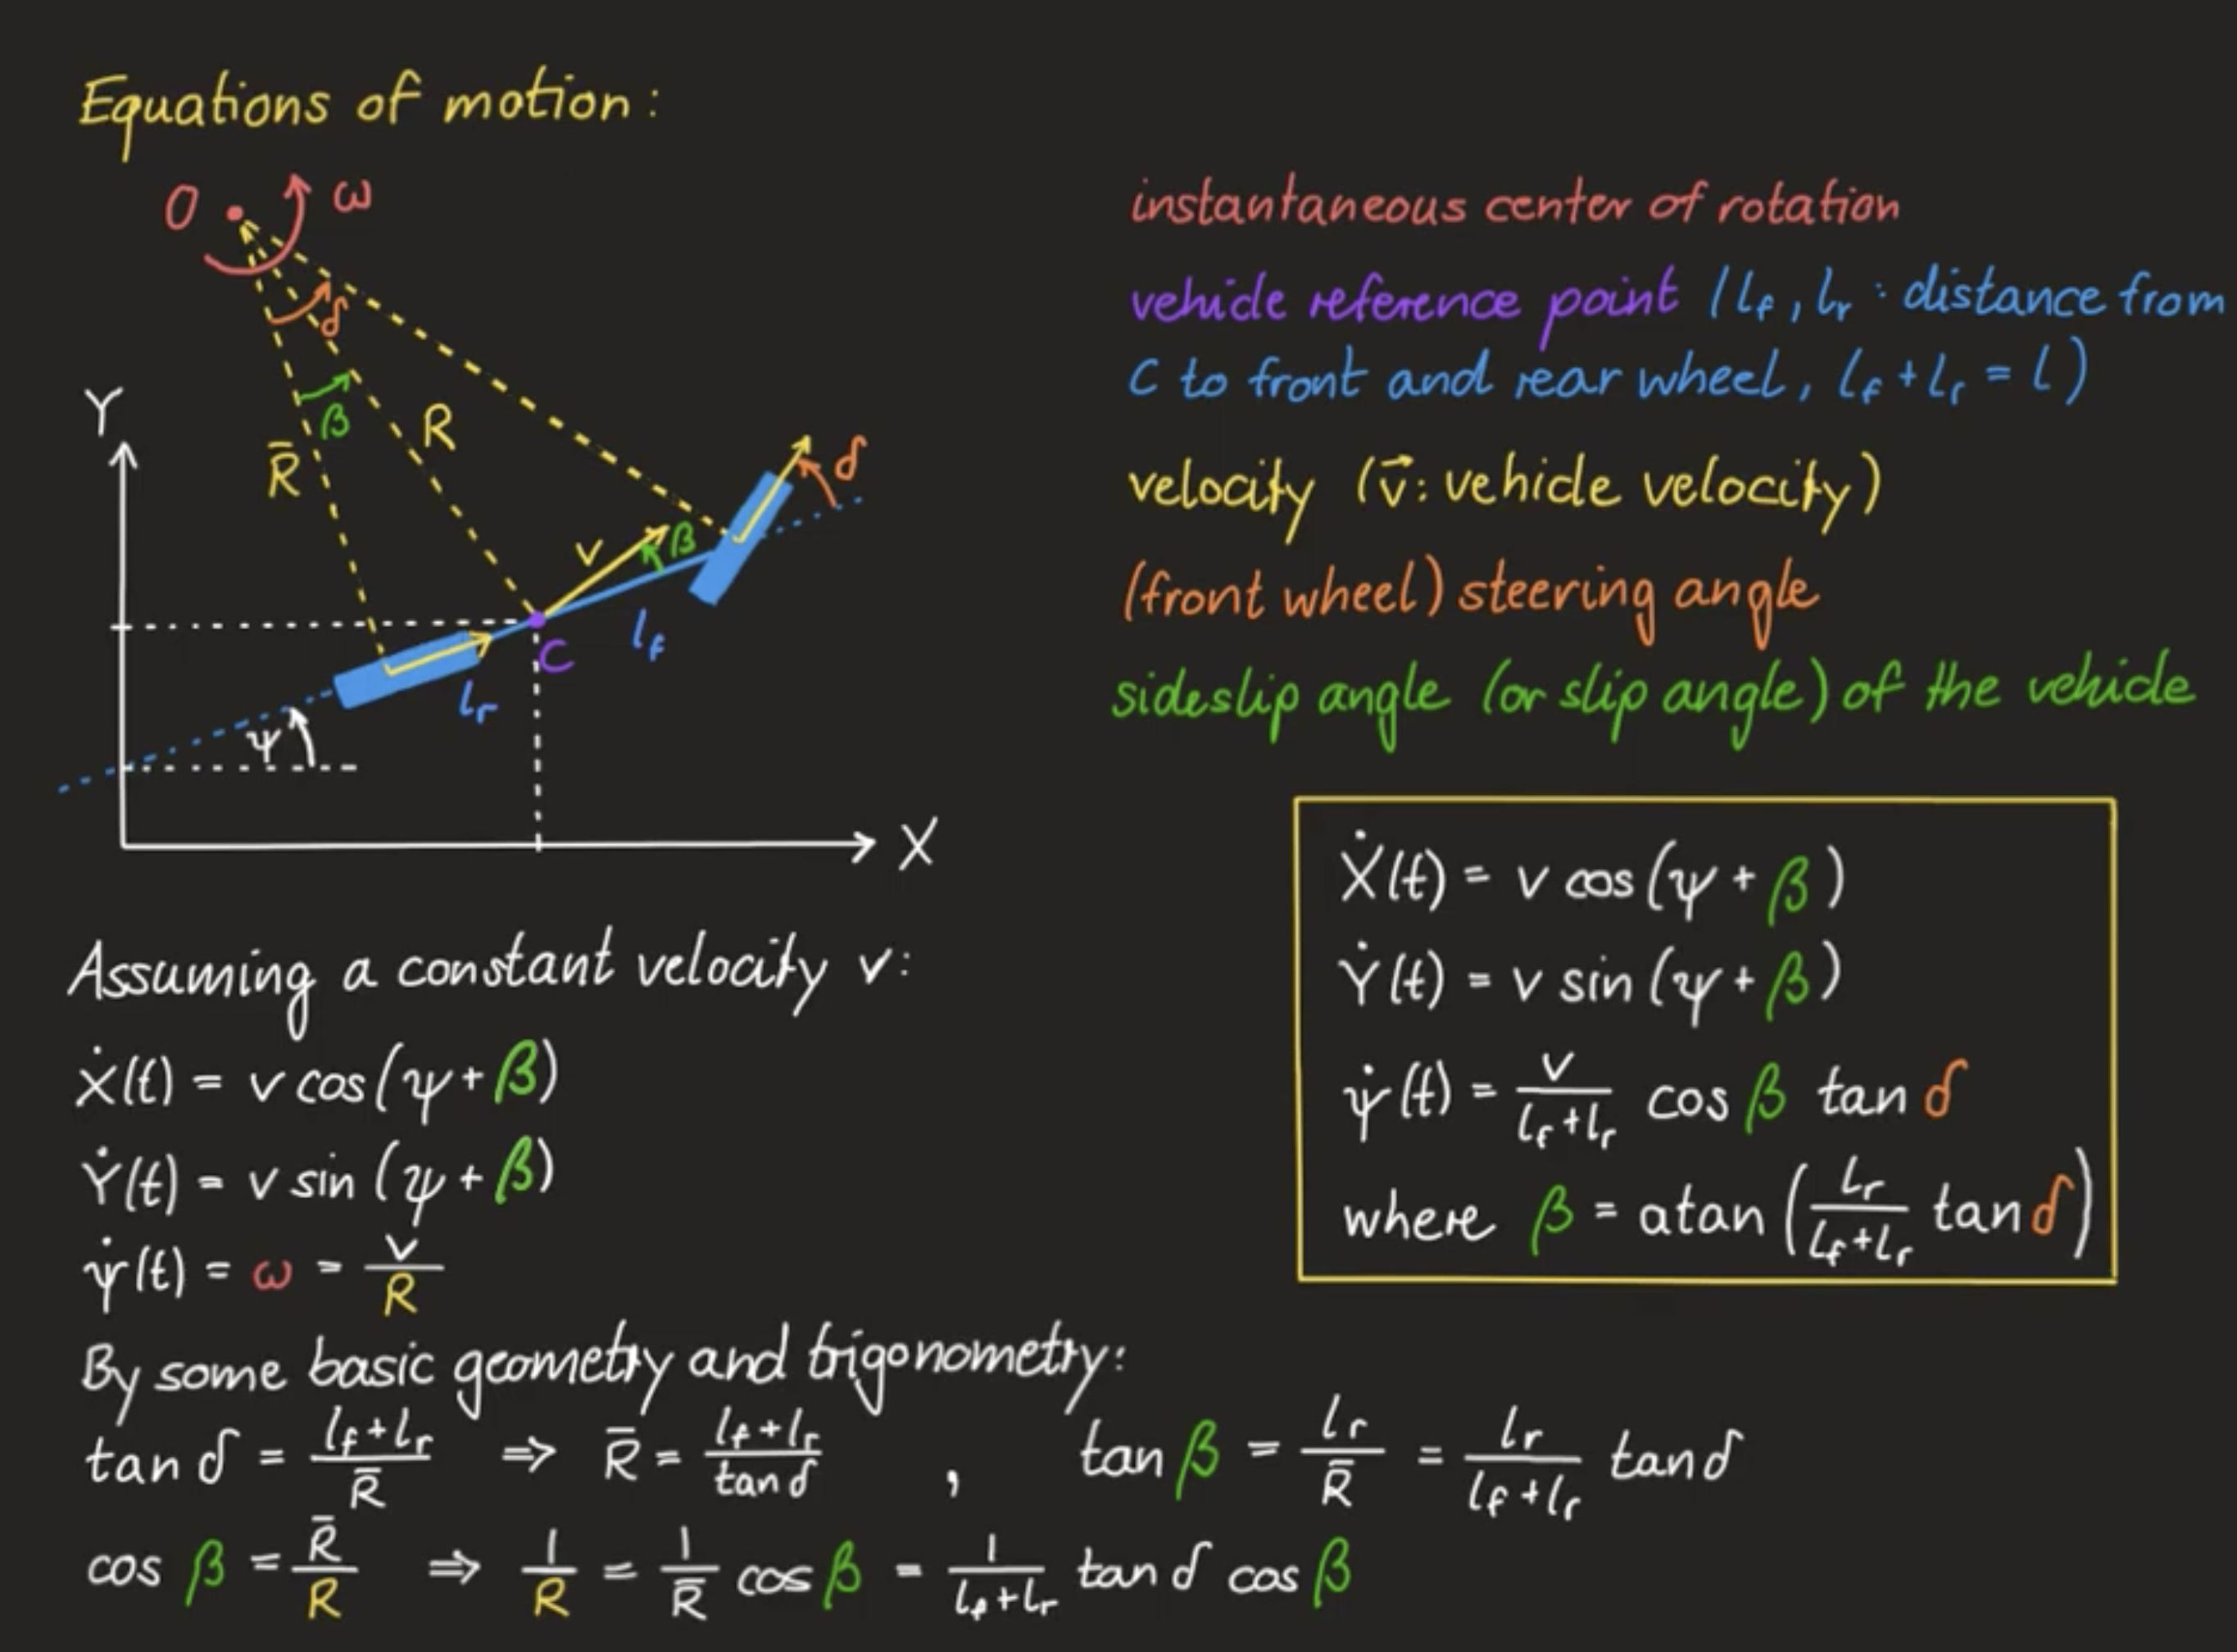

In [196]:
from IPython.display import Image
Image(filename='pic1.png') 

In [197]:
# in above terms
wheelbase = 2.630
lr = 1.55
lf = wheelbase - lr

Из приближающих окружностей (значений их радиусов $R_i$) получим предполагаемые значения угла поворота по формуле

$$
\angle \delta_i = \arctan (\frac{l_f + l_r}{\overline{R_i}}) = \arctan (\frac{l_f + l_r}{\sqrt{R_i^2 - l_r^2}})
$$ 

In [199]:
deltas = []
for circle in circles:
    _, _, R = circle
    delta = np.arctan((lr + lf) / np.sqrt(R * R - lr * lr))
    deltas.append(delta)

<ipython-input-199-1d2b75d2294d>:4: RuntimeWarning: invalid value encountered in sqrt
  delta = np.arctan((lr + lf) / np.sqrt(R * R - lr * lr))


In [253]:
deltas_for_all = []
i = 0
for arc in arcs:
    if len(arc) >= 3:
        deltas_for_all += [deltas[i]] * len(arc)
        i += 1
    else:
        deltas_for_all += [None] * len(arc)

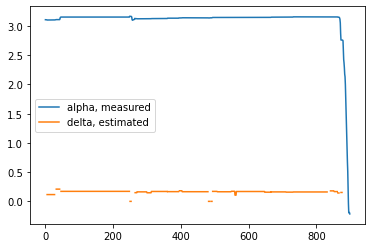

In [254]:
plt.plot(total_alphas, label='alpha, measured')
plt.plot(deltas_for_all, label='delta, estimated')
plt.legend()
plt.show()

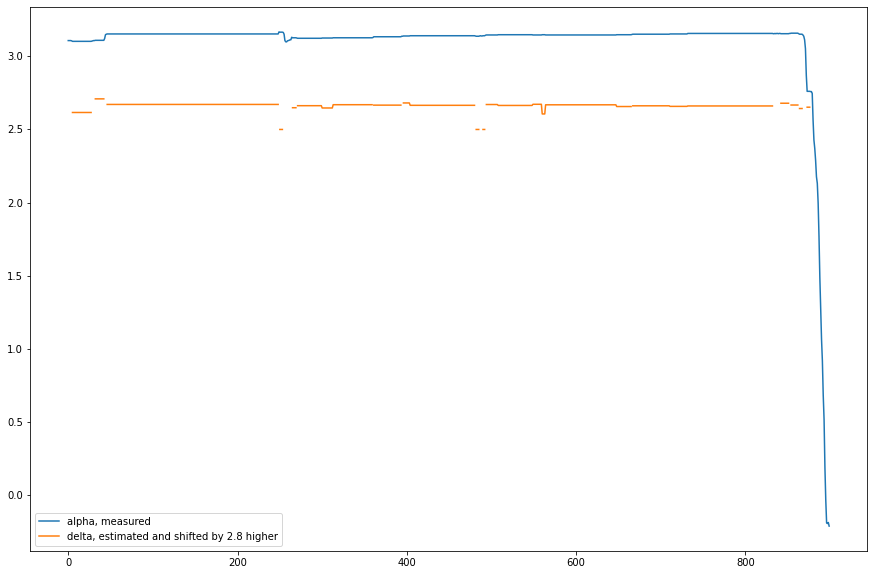

In [256]:
# shift deltas for closer view
deltas_for_all_shifted = [delta + 2.5 if delta is not None else None for delta in deltas_for_all]

plt.figure(figsize=(15,10))
plt.plot(total_alphas, label='alpha, measured')
plt.plot(deltas_for_all_shifted, label='delta, estimated and shifted by 2.8 higher')
plt.legend()
plt.show()